<a href="https://colab.research.google.com/github/Ilya-Sed/mipt_Beeline/blob/main/bert_pavlov_finetune_hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
# прикрутим драйв

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

# Загрузка модели и токенизатора
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

# Функция для получения вероятностей слов
def get_word_probabilities(text):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    softmax_probs = torch.nn.functional.softmax(logits, dim=-1)
    word_probs = softmax_probs[0, range(len(inputs.input_ids[0])), inputs.input_ids[0]]
    return word_probs

# Пример использования функции
text = "пример текста на русском языке"
word_probs = get_word_probabilities(text)
for word, prob in zip(tokenizer.tokenize(text), word_probs):
    print(f"Word: {word}, Probability: {prob.item()}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Word: пример, Probability: 1.928898818448488e-08
Word: текста, Probability: 0.03008160926401615
Word: на, Probability: 0.9513587951660156
Word: русском, Probability: 0.9999852180480957
Word: языке, Probability: 0.9997652173042297


In [ ]:
# считываем данные

import pandas as pd

# Try reading the CSV file while specifying the delimiter and handling bad lines
try:
    data = pd.read_csv('/content/drive/MyDrive/MIPT/hackaton_result_dataset 2.csv', sep=';', on_bad_lines='skip')
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

data.drop('Unnamed: 4', inplace=True, axis=1)
data.drop('audio_path', inplace=True, axis=1)


# отлично, теперь у нас есть чистая дата, добавим ппризнак и попробуем найти кореляцию
data

,model_annotation,human_markup,label
0,давай по россии значит на коленях быстро блять...,давай проси значит на коленях быстро блять,1
1,ну разве можно так с телефоном поступает,ну что ну разве можно так с телефоном поступать,0
2,у меня нет с собой в полном адресе я щас дома ...,у меня нет с собой полного адреса я щас из дом...,0
3,а я здесь кто я санитар,а я знаешь кто я санитар,0
4,дежурный по кузьминскому военнокомату,дежурный по кузьминскому военкомату,0
...,...,...,...
6502,это студия,вот это не твое дело стой,1
6503,потише говори у меня рядом течение вдруг сидит...,блять ну ты потише говори у меня рядом чеченец...,0
6504,если в поймаю дай бог а зачем тогда будешь рез...,если поймаю их дай а чем ты будешь меня резать...,1
6505,а ты все удобром что ли а че будет алло алло т...,а ты че там в гудок прям чтоли а че ало ало ты...,1


## Здесь учим берта методом маскирования

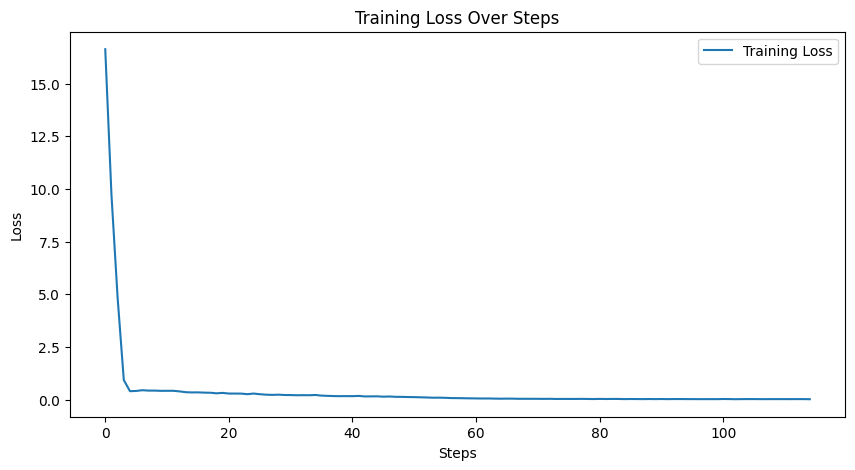

Epoch: 3, Step: 27, Loss: 0.018637413159012794


In [ ]:
# обучим ruBert на данных размеченных человеком

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForMaskedLM, AdamW
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Тексты распознанные человеком
texts = list(data['human_markup'])

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512, mlm_probability=0.15):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mlm_probability = mlm_probability

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = inputs['input_ids'].clone()

        # Маскировка части токенов
        probability_matrix = torch.full(inputs['input_ids'].shape, self.mlm_probability)
        special_tokens_mask = self.tokenizer.get_special_tokens_mask(inputs['input_ids'], already_has_special_tokens=True)
        probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool()
        inputs['input_ids'][masked_indices] = self.tokenizer.mask_token_id

        return inputs

# Настройка
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
dataset = TextDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=150, shuffle=True)

model = BertForMaskedLM.from_pretrained('DeepPavlov/rubert-base-cased')
model.train()

# Настройка оптимизатора
optimizer = AdamW(model.parameters(), lr=5e-5)

# Устройство для вычислений (GPU или CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Сохранение данных по loss
loss_mask_bert = []

# Функция для обновления графика
def update_plot(losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Steps')
    plt.legend()
    plt.show()

# Процесс дообучения
epochs = 20
for epoch in range(epochs):
    epoch_loss = 0
    for step, batch in enumerate(dataloader):
        # Переносим данные на устройство
        inputs = {key: val.to(device) for key, val in batch.items()}

        # Получаем выходы модели
        outputs = model(**inputs)
        loss = outputs.loss

        # Обратное распространение ошибки и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Очистка кэша после каждого шага
        torch.cuda.empty_cache()

        step_loss = loss.item()
        epoch_loss += step_loss
        loss_mask_bert.append(step_loss)

        print(f"Epoch: {epoch + 1}, Step: {step + 1}, Loss: {step_loss}")

        update_plot(loss_mask_bert)

        print(f"Epoch: {epoch + 1}, Step: {step + 1}, Loss: {step_loss}")

    epoch_loss /= len(dataloader)
    print(f"Epoch: {epoch + 1}, Average Loss: {epoch_loss}")

# Сохранение дообученной модели
model.save_pretrained('./fine_tuned_rubert2')
tokenizer.save_pretrained('./fine_tuned_rubert2')

# Финальное построение графика изменения loss
update_plot(loss_mask_bert)


## Начиная отсюда работаем по подготовке данных, используя обученный BERT

In [ ]:
# считаем и подготовим данные
import pandas as pd
# Try reading the CSV file while specifying the delimiter and handling bad lines
try:
    data = pd.read_csv('drive/MyDrive/MIPT/hackaton_result_dataset 2.csv', sep=';', on_bad_lines='skip')
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

data.drop('Unnamed: 4', inplace=True, axis=1)
data.drop('audio_path', inplace=True, axis=1)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random


## Здесь подготовка данных исходная, отделим тестовую выборку в самом начале, чтобы не было утечки

In [ ]:
# разделим данные на обучающую и тестовую выборки

from sklearn.model_selection import train_test_split

data = data.drop('human_markup', axis=1)

df_train, df_test = train_test_split(data, test_size=0.25, random_state=42)

In [ ]:
df_train.shape

(4880, 2)

## здесь дополнительно учим BERT но уже на задачу классификации (отсюда возьмем вероятности классов)

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs


# Настройка токенизатора и модели
model_path = '/content/drive/MyDrive/MIPT/fine_tuned_rubert'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Подготовка данных
train_dataset = ClassificationDataset(df_train['model_annotation'].tolist(), df_train['label'].tolist(), tokenizer)
test_dataset = ClassificationDataset(df_test['model_annotation'].tolist(), df_test['label'].tolist(), tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=350, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=350, shuffle=False)

# Настройка модели и оптимизатора
model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Обучение модели
epochs = 20
for epoch in range(epochs):
    for step, batch in enumerate(train_dataloader):
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch + 1}, Step: {step + 1}, Loss: {loss.item()}")

# Сохранение модели
model.save_pretrained('/content/drive/MyDrive/MIPT/fine_tuned_classifier2')
tokenizer.save_pretrained('/content/drive/MyDrive/MIPT/fine_tuned_classifier2')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Step: 1, Loss: 0.7111061215400696
Epoch: 1, Step: 2, Loss: 0.9380894899368286
Epoch: 1, Step: 3, Loss: 0.6827394366264343
Epoch: 1, Step: 4, Loss: 0.6784656643867493
Epoch: 1, Step: 5, Loss: 0.69315105676651
Epoch: 1, Step: 6, Loss: 0.6909857392311096
Epoch: 1, Step: 7, Loss: 0.6716157793998718
Epoch: 1, Step: 8, Loss: 0.6624055504798889
Epoch: 1, Step: 9, Loss: 0.6722642183303833
Epoch: 1, Step: 10, Loss: 0.686785101890564
Epoch: 1, Step: 11, Loss: 0.6669790148735046
Epoch: 1, Step: 12, Loss: 0.677081286907196
Epoch: 1, Step: 13, Loss: 0.657536506652832
Epoch: 1, Step: 14, Loss: 0.6645589470863342
Epoch: 1, Step: 15, Loss: 0.6558724641799927
Epoch: 1, Step: 16, Loss: 0.652752697467804
Epoch: 1, Step: 17, Loss: 0.6619242429733276
Epoch: 1, Step: 18, Loss: 0.6340976357460022
Epoch: 1, Step: 19, Loss: 0.6410375833511353
Epoch: 1, Step: 20, Loss: 0.5668684840202332
Epoch: 2, Step: 1, Loss: 0.6618740558624268
Epoch: 2, Step: 2, Loss: 0.6609688401222229
Epoch: 2, Step: 3, Loss: 0.

## начинаем составлять альтернативное представление признаков

In [ ]:
# Первое что сделаем: методом максирования представим условные вероятности каждого слова
from transformers import BertTokenizer, BertForMaskedLM
import torch
# Настройка токенизатора и модели
model_path = '/content/drive/MyDrive/MIPT/fine_tuned_rubert'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)

# Функция для получения вероятностей слов
def get_word_probabilities(text):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    softmax_probs = torch.nn.functional.softmax(logits, dim=-1)
    word_probs = softmax_probs[0, range(len(inputs.input_ids[0])), inputs.input_ids[0]]
    return word_probs

# Пример использования функции
text = "пример текста на метамодернизм языке"
word_probs = get_word_probabilities(text)
for word, prob in zip(tokenizer.tokenize(text), word_probs):
    print(f"Word: {word}, Probability: {prob.item()}")

# работает странно, попробуем что-то еще)


Word: пример, Probability: 0.9979346990585327
Word: текста, Probability: 0.9991795420646667
Word: на, Probability: 0.9963428378105164
Word: метам, Probability: 0.9999359846115112
Word: ##одер, Probability: 0.9994112253189087
Word: ##низ, Probability: 0.9999892711639404
Word: ##м, Probability: 0.9997830986976624
Word: языке, Probability: 0.9980339407920837


1) Берем первое слово из данной фразы получаем максимальную вероятность следующего слова
2) Брем первые два слова из данный фразы, получаем максимальную вероятность следующего слова (третьего по мнению модели)
3) Берем первые три слова

И так далее пока не берем n-1 слов в последовательности N слов и вычисляем вероятность последнего слова

У нас получается вектор чисел вероятностей слов в данной фразе
И вектор чисел вероятностей во фразе где каждое следующее слово предложено моделью

Далее надо отнять первый эелмент из первого вектора (первое слово), вектора стали одинаковой длины, поэлементно перемножить и сложить произведения
Поэлементно вычесть второй вектор из первого и сложить результаты разницы

В результате получится кортеж из двух чисел

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
import numpy as np

# Загрузка дообученного токенизатора и модели
model_path = '/content/drive/MyDrive/MIPT/fine_tuned_rubert'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)

# Функция для получения вероятностей и предсказанных вероятностей слов
def get_probabilities_and_predictions(text):
    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs['input_ids']
    real_probabilities = []
    predicted_probabilities = []

    for i in range(1, input_ids.size(1) - 1):  # Пропускаем первый и последний токены (CLS и SEP)
        masked_input_ids = input_ids.clone()
        masked_input_ids[0, i] = tokenizer.mask_token_id  # Маскируем текущее слово

        with torch.no_grad():
            outputs = model(masked_input_ids)

        logits = outputs.logits
        softmax_probs = torch.nn.functional.softmax(logits, dim=-1)

        real_word_prob = softmax_probs[0, i, input_ids[0, i]].item()  # Вероятность маскированного слова
        real_probabilities.append(real_word_prob)

        predicted_next_word_id = torch.argmax(logits[0, i]).item()  # Индекс наиболее вероятного следующего слова
        predicted_word_prob = softmax_probs[0, i, predicted_next_word_id].item()  # Вероятность наиболее вероятного следующего слова
        predicted_probabilities.append(predicted_word_prob)

    return real_probabilities, predicted_probabilities

# Функция для вычисления результата
def calculate_result(real_probs, predicted_probs):
    real_probs = real_probs[1:]  # Удаляем первый элемент
    combined_prob_product = sum([r * p for r, p in zip(real_probs, predicted_probs)])
    combined_prob_difference = sum([r - p for r, p in zip(real_probs, predicted_probs)])
    return combined_prob_product, combined_prob_difference

# Пример использования функций
text = "патисоны растут кванторами вверх"
real_probs, predicted_probs = get_probabilities_and_predictions(text)
result = calculate_result(real_probs, predicted_probs)
print(f"Result: {result}")


Result: (0.7124262559554915, -2.0278780164708223)


In [ ]:
# рассчитаем вероятности классов в обучающей и тестовой выборке

# Загрузка дообученного токенизатора и модели
model_path = '/content/drive/MyDrive/MIPT/fine_tuned_classifier'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()


def predict_proba(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs[0].tolist()  # вероятности классов 0 и 1

# Получение вероятностей для обучающей выборки
df_train['class_0_prob'], df_train['class_1_prob'] = zip(*df_train['model_annotation'].apply(predict_proba))

# Получение вероятностей для тестовой выборки
df_test['class_0_prob'], df_test['class_1_prob'] = zip(*df_test['model_annotation'].apply(predict_proba))

print(df_train.head())
print(df_test.head())

KeyboardInterrupt: 

In [ ]:
# Отлично, у нас есть трейн и тест с дополненными фичами.
# Теперь добавим два признака вероятностей слов

# ооочень долго проходит инференс и дополнение датасета, 6 000 строк за полчаса на TPU

# Применение функций к обучающей выборке
train_features = df_train['model_annotation'].apply(lambda x: calculate_result(*get_probabilities_and_predictions(x)))
df_train['combined_prob_product'], df_train['combined_prob_difference'] = zip(*train_features)

# Применение функций к тестовой выборке
test_features = df_test['model_annotation'].apply(lambda x: calculate_result(*get_probabilities_and_predictions(x)))
df_test['combined_prob_product'], df_test['combined_prob_difference'] = zip(*test_features)


df_test.head()

,model_annotation,label,class_0_prob,class_1_prob,combined_prob_product,combined_prob_difference
3393,во женая плоды,1,0.185525,0.814475,0.000590,-0.246519
4909,ты плачу выехала все по ходу пятьсот,1,0.321547,0.678452,0.132777,-1.639957
4815,компания компан,1,0.180639,0.819361,0.003746,-0.293120
3434,все вот у меня будет все говорить блять,1,0.505931,0.494069,1.010681,-1.119896
96,более не существует но тем не менее,0,0.672602,0.327398,0.598801,-1.001744


In [ ]:
# сохраним промежуточный результат

df_test.to_csv('/content/drive/MyDrive/MIPT/data_test_propadd.csv', index=False)
df_train.to_csv('/content/drive/MyDrive/MIPT/data_train_data_propadd.csv', index=False)

In [ ]:
df_train.shape

(4880, 6)

## теперь добавим это признаковое описание к обучающей и тестовой выборке

In [ ]:
# сгененрируем эмбединги для каждой фразы длиной 64 (через PCA) и положим в модель

from sklearn.decomposition import PCA

# Загрузка дообученного токенизатора и модели
model_path = '/content/drive/MyDrive/MIPT/fine_tuned_rubert'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)
model.eval()

# Функция для получения эмбеддингов
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state  # Получаем последний скрытый слой
    embeddings = torch.mean(hidden_states, dim=1)  # Усредняем скрытые состояния по токенам
    return embeddings.squeeze().cpu().numpy()

# Применение функции к обучающей выборке
train_embeddings = df_train_add['model_annotation'].apply(get_embeddings)
train_embeddings = np.vstack(train_embeddings)  # Преобразуем список эмбеддингов в массив

# Применение функции к тестовой выборке
test_embeddings = df_test_add['model_annotation'].apply(get_embeddings)
test_embeddings = np.vstack(test_embeddings)  # Преобразуем список эмбеддингов в массив

# Применение PCA для уменьшения размерности до 16
pca = PCA(n_components=16)
train_embeddings_pca = pca.fit_transform(train_embeddings)
test_embeddings_pca = pca.transform(test_embeddings)

print(train_embeddings_pca.shape)
print(test_embeddings_pca.shape)

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/MIPT/fine_tuned_rubert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


(1627, 16)
(4880, 16)


In [ ]:

# Добавление эмбеддингов в DataFrame как отдельные столбцы
df_train_embeddings = pd.DataFrame(train_embeddings_pca, columns=[f'e{i}' for i in range(16)])
df_train_add = pd.concat([df_train_add.reset_index(drop=True), df_train_embeddings.reset_index(drop=True)], axis=1)

df_test_embeddings = pd.DataFrame(test_embeddings_pca, columns=[f'e{i}' for i in range(16)])
df_test_add = pd.concat([df_test_add.reset_index(drop=True), df_test_embeddings.reset_index(drop=True)], axis=1)

print(df_train_add.shape)
print(df_test_add.shape)

(1627, 22)
(4880, 22)


In [ ]:
list(df_test.columns)

['model_annotation', 'label']

In [ ]:
df_train_add.head()

,model_annotation,label,class_0_prob,class_1_prob,combined_prob_product,combined_prob_difference
0,во женая плоды,1,0.185525,0.814475,0.000590,-0.246519
1,ты плачу выехала все по ходу пятьсот,1,0.321547,0.678452,0.132777,-1.639957
2,компания компан,1,0.180639,0.819361,0.003746,-0.293120
3,все вот у меня будет все говорить блять,1,0.505931,0.494069,1.010681,-1.119896
4,более не существует но тем не менее,0,0.672602,0.327398,0.598801,-1.001744


In [ ]:
import pandas as pd

df_train_add = pd.read_csv('/content/drive/MyDrive/MIPT/data_test_propadd.csv')
df_test_add = pd.read_csv('/content/drive/MyDrive/MIPT/data_train_data_propadd.csv')

In [ ]:

df_test_add

,model_annotation,label,class_0_prob,class_1_prob,combined_prob_product,combined_prob_difference,e0,e1,e2,e3,...,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15
0,а что вы хотели то вас с кем то соединить или ...,0,0.901286,0.098714,9.036181e-01,-4.582781,-3.367384,-0.834753,0.885328,2.566495,...,-1.150203,0.725577,0.309876,0.114710,0.928392,0.861224,-0.757782,0.388085,-0.108483,-0.175552
1,я ничего не перепутал это мне звонила женщина ...,0,0.894002,0.105998,4.310567e-01,-2.681361,-2.161093,-1.510608,-0.650351,1.355620,...,1.312657,0.095443,-0.142141,-0.406619,-0.150935,0.103906,-0.312497,-0.556783,0.253147,-1.422435
2,курочка кукарекает иначе,0,0.226498,0.773502,5.005734e-01,-0.338291,0.223625,0.734008,-1.496493,-0.776466,...,-0.091956,-0.676640,1.190392,-1.061103,0.032422,0.046564,-0.905945,-0.725379,-0.397366,-1.223547
3,сходила школьный двое поддал футбол там ребята...,1,0.860082,0.139918,5.712168e-01,-3.700094,-2.393469,-0.457073,1.016542,-0.711428,...,0.245143,-1.331920,-1.629365,-0.084838,-0.022862,0.268683,1.199026,-0.919316,-0.236677,0.306476
4,получение не удовольствие от самого процесса с...,1,0.687805,0.312195,5.972034e-02,-0.505373,0.265536,1.449021,1.737980,0.463892,...,0.112626,0.695810,-0.494474,-0.829308,-0.101637,-0.877648,0.067431,-0.416690,-0.226574,-0.884467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4875,тебе звонок из настал почему это,0,0.839066,0.160934,4.253521e-03,-0.986846,-0.421873,0.271138,-0.265583,1.131749,...,-0.627836,-1.684739,-0.691549,-1.310752,0.703522,-0.415710,-1.130695,-0.390637,-0.350715,0.353864
4876,че хотели от нас,0,0.187205,0.812796,1.564093e-03,-1.162872,0.589838,-0.302176,0.065036,0.163941,...,-1.377784,-0.358521,1.292855,0.280625,-0.071280,0.735713,-1.030653,0.775904,-0.418388,0.429386
4877,это весь запас словахный нет,0,0.349011,0.650989,1.157720e-03,-0.659255,0.506705,1.869215,0.920004,1.642319,...,-0.224870,0.340182,-0.529707,0.793716,0.019300,-0.637674,0.488372,1.542255,1.383441,0.512762
4878,это областной,1,0.239422,0.760578,9.514602e-07,-0.097542,3.860250,0.787640,-0.491057,2.384595,...,-0.768614,-0.574881,-0.275929,0.645891,0.134236,-0.047648,0.757447,-0.291093,0.790550,0.946525


In [ ]:
df_train_add_ready = df_train_add.drop(['model_annotation', 'class_0_prob'], axis=1)
df_test_add_ready = df_test_add.drop(['model_annotation', 'class_0_prob'], axis=1)

In [ ]:
df_train_add.shape

(1627, 22)

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Генерация полиномиальных фич
poly = PolynomialFeatures(degree=7, include_bias=False)
train_poly_features = poly.fit_transform(df_train_add_ready[['class_1_prob', 'combined_prob_product', 'combined_prob_difference']])
test_poly_features = poly.transform(df_test_add_ready[['class_1_prob', 'combined_prob_product', 'combined_prob_difference']])

# Добавление полиномиальных фич в DataFrame
df_train_poly = pd.DataFrame(train_poly_features, columns=poly.get_feature_names_out(['class_1_prob', 'combined_prob_product', 'combined_prob_difference']))
df_test_poly = pd.DataFrame(test_poly_features, columns=poly.get_feature_names_out(['class_1_prob', 'combined_prob_product', 'combined_prob_difference']))

df_train_add_ready = pd.concat([df_train_add_ready.reset_index(drop=True), df_train_poly.reset_index(drop=True)], axis=1)
df_test_add_ready = pd.concat([df_test_add_ready.reset_index(drop=True), df_test_poly.reset_index(drop=True)], axis=1)

# Построение модели SVM и подбор гиперпараметров
param_grid_svm = {
    'svc__C': [0.1, 1, 10, 100, 1000],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

pipeline_svm = Pipeline([
    ('svc', SVC(probability=True))
])

grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Построение модели Gradient Boosting и подбор гиперпараметров
param_grid_gb = {
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.001, 0.01, 0.1],
    'gb__max_depth': [3, 4, 5, 10]
}

pipeline_gb = Pipeline([
    ('gb', GradientBoostingClassifier())
])

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Вывод оптимальных параметров и оценка моделей
best_model_svm = grid_search_svm.best_estimator_
y_pred_proba_svm = best_model_svm.predict_proba(X_test)[:, 1]

roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

best_model_gb = grid_search_gb.best_estimator_
y_pred_proba_gb = best_model_gb.predict_proba(X_test)[:, 1]
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Best SVM parameters: {grid_search_svm.best_params_}")
print(f"SVM ROC-AUC: {roc_auc_svm}")
print(f"Best Gradient Boosting parameters: {grid_search_gb.best_params_}")
print(f"Gradient Boosting ROC-AUC: {roc_auc_gb}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best SVM parameters: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
SVM ROC-AUC: 0.6548120427194687
Best Gradient Boosting parameters: {'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__n_estimators': 300}
Gradient Boosting ROC-AUC: 0.6783379823831204


In [ ]:
# Добавим предсказания SVM и градиентного бустинга в таблицу

y_pred_train_svm = best_model_svm.predict_proba(X_train)[:, 1]
y_pred_train_gb = best_model_gb.predict_proba(X_train)[:, 1]

In [ ]:
df_train_add_ready['svm'] = y_pred_train_svm
df_train_add_ready['gb'] = y_pred_train_gb
df_test_add_ready['svm'] = y_pred_proba_svm
df_test_add_ready['gb'] = y_pred_proba_gb

In [ ]:
df_test_add_ready.shape

(4880, 141)

In [ ]:
# теперь попробуем построить и обучить

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


X_train = df_train_add_ready.drop(columns=['label'])
y_train = df_train_add_ready['label'].values
X_test = df_test_add_ready.drop(columns=['label'])
y_test = df_test_add_ready['label'].values

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создание датасетов и загрузчиков данных
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(140, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))
        return x

# Определение модели, функции потерь и оптимизатора
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Оценка модели
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

roc_auc = roc_auc_score(y_true, y_pred)
print(f"ROC-AUC: {roc_auc}")

Epoch 1, Loss: 0.6899450591632298
Epoch 2, Loss: 0.6881166866847447
Epoch 3, Loss: 0.6872374074799674
Epoch 4, Loss: 0.6858552268573216
Epoch 5, Loss: 0.684555743421827
Epoch 6, Loss: 0.682529628276825
Epoch 7, Loss: 0.6802287953240531
Epoch 8, Loss: 0.6782143712043762
Epoch 9, Loss: 0.6748533844947815
Epoch 10, Loss: 0.6702867661203656
Epoch 11, Loss: 0.6659541215215411
Epoch 12, Loss: 0.6591502513204303
Epoch 13, Loss: 0.6531386460576739
Epoch 14, Loss: 0.6431316222463336
Epoch 15, Loss: 0.6349199754851205
Epoch 16, Loss: 0.6190664172172546
Epoch 17, Loss: 0.6035285421780178
Epoch 18, Loss: 0.5864740354674203
Epoch 19, Loss: 0.5667657852172852
Epoch 20, Loss: 0.5466728210449219
Epoch 21, Loss: 0.5224927238055638
Epoch 22, Loss: 0.49692999039377483
Epoch 23, Loss: 0.46383645704814364
Epoch 24, Loss: 0.44361856154033114
Epoch 25, Loss: 0.40367596064295086
Epoch 26, Loss: 0.37249361191477093
Epoch 27, Loss: 0.3358701893261501
Epoch 28, Loss: 0.2980371287890843
Epoch 29, Loss: 0.26020337

In [ ]:
# Удаление текстовой колонки и колонки class_0_prob
df_train = df_train.drop(columns=['text'])
df_test = df_test.drop(columns=['text'])

# Генерация полиномиальных фич
poly = PolynomialFeatures(degree=4, include_bias=False)
train_poly_features = poly.fit_transform(df_train[['class_1_prob', 'combined_prob_product', 'combined_prob_difference']])
test_poly_features = poly.transform(df_test[['class_1_prob', 'combined_prob_product', 'combined_prob_difference']])

# Добавление полиномиальных фич в DataFrame
df_train_poly = pd.DataFrame(train_poly_features, columns=poly.get_feature_names_out(['class_1_prob', 'combined_prob_product', 'combined_prob_difference']))
df_test_poly = pd.DataFrame(test_poly_features, columns=poly.get_feature_names_out(['class_1_prob', 'combined_prob_product', 'combined_prob_difference']))

df_train = pd.concat([df_train.reset_index(drop=True), df_train_poly.reset_index(drop=True)], axis=1)
df_test = pd.concat([df_test.reset_index(drop=True), df_test_poly.reset_index(drop=True)], axis=1)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train.drop(columns=['label']))
X_test = scaler.transform(df_test.drop(columns=['label']))
y_train = df_train['label']
y_test = df_test['label']

# Построение модели SVM и подбор гиперпараметров
param_grid_svm = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

pipeline_svm = Pipeline([
    ('svc', SVC(probability=True))
])

grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Построение модели Gradient Boosting и подбор гиперпараметров
param_grid_gb = {
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 4, 5]
}

pipeline_gb = Pipeline([
    ('gb', GradientBoostingClassifier())
])

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Вывод оптимальных параметров и оценка моделей
best_model_svm = grid_search_svm.best_estimator_
y_pred_proba_svm = best_model_svm.predict_proba(X_test)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

best_model_gb = grid_search_gb.best_estimator_
y_pred_proba_gb = best_model_gb.predict_proba(X_test)[:, 1]
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Best SVM parameters: {grid_search_svm.best_params_}")
print(f"SVM ROC-AUC: {roc_auc_svm}")
print(f"Best Gradient Boosting parameters: {grid_search_gb.best_params_}")
print(f"Gradient Boosting ROC-AUC: {roc_auc_gb}")

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Загрузка модели
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/MIPT/fine_tuned_classifier')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/MIPT/fine_tuned_classifier')
model.eval()

def predict(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

def predict_proba(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs[0][1].item()  # вероятность класса 1

# Получение предсказаний для тестовой выборки
df_test['predicted'] = df_test['model_annotation'].apply(predict)

# Подсчет accuracy
accuracy = accuracy_score(df_test['label'], df_test['predicted'])
print(f"Accuracy: {accuracy}")

# Получение вероятностей и подсчет ROC-AUC
df_test['prob'] = df_test['model_annotation'].apply(predict_proba)
roc_auc = roc_auc_score(df_test['label'], df_test['prob'])
print(f"ROC-AUC: {roc_auc}")


Accuracy: 0.6739754098360655
ROC-AUC: 0.7153155078938569
